Fitness Fatigue Models Illustrative Code
=========================================

This is a companion notebook illustrating the fitness fatigue models discussed in our review series. The easiest way to run or edit this notebook to visit the latest [Kaggle version](https://www.kaggle.com/baogorek/fitness-fatigue-models-illustrative-code), but you may also host it yourself (see [README.md](./README.md)).

## Dependencies
 - [example_loads.csv](https://www.kaggle.com/baogorek/example-training-loads), a data set of example training loads created by @bsh2020.
 - [ffmfunctions.R](https://www.kaggle.com/baogorek/ffmfunctions), an R script containing functions relevant to the Fitness Fatigue model and variations discussed in our review papers

In [1]:
# These paths are relative to Kaggle servers
source("ffmfunctions.R")
example_loads <- read.csv("example_loads.csv")

set.seed(523445)  # Seed for reproducible output

[1] "Version 16"


## Training loads

In this research, the raw training loads $\omega^i$ are taken to be exogenous, i.e., coming from some predetermined plan, not a downstream impact of actual performance. It is represented in the code as `w`.

As noted in the dependencies, this notebook is accompied by an extensive training load dataset, which uses real exercises and separates upper body from lower body training impulses. These may be used below by choosing `training_type` to be either `"upper body"` or `"lower body"`. In addition there is also a fully synthetic option, `"synthetic"` that creates variation oportunistically, such as a long rest in the middle of the program so that fitness has time to fade. 


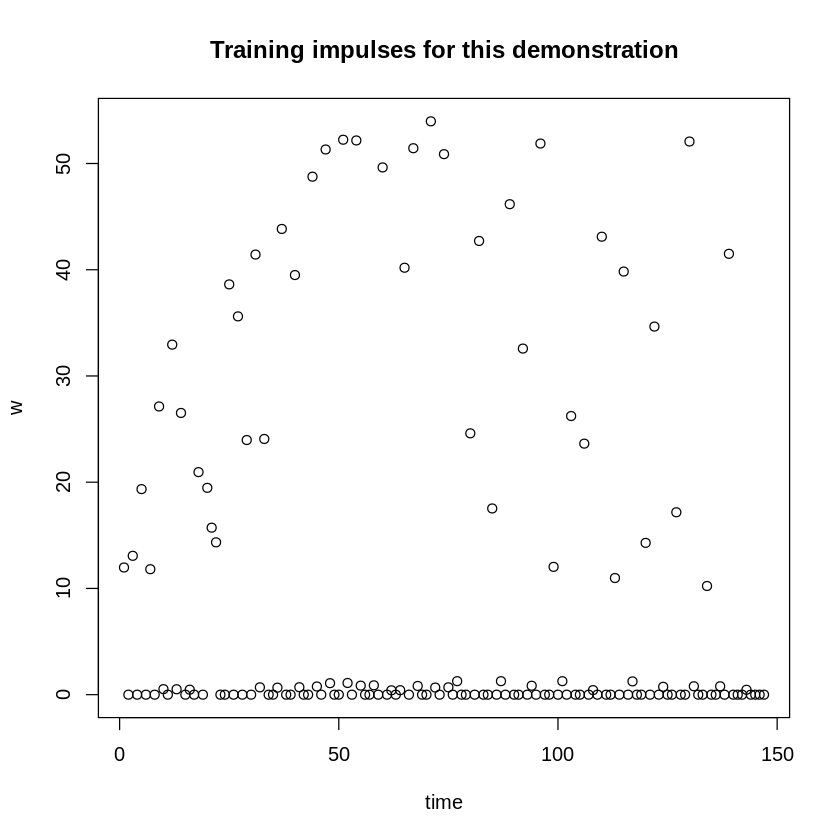

In [2]:
# The Training Plan -----------------------------------------------------------

# "upper body", "lower body", "synthetic"
training_type <- "upper body" 

if (training_type == "synthetic") {
  w <- rep(c(seq(10, 50), rep(20, 14)), 5)
  w <- c(w, rep(0, 100), w)  #  Adding long rest!
} else if (training_type == "upper body") {
  w <- as.numeric(example_loads$tl_upper_fitness)
} else if (training_type == "lower body") {
  w <- as.numeric(example_loads$tl_lower_fitness)
}

plot(w, main = "Training impulses for this demonstration", xlab = "time")

## The Basic Model

The basic 5-parameter Fitness Fatigue Model from our review is:

$$
\hat{p}_n = p^{\star} + k_g \sum_{i=1}^{n-1} \omega_i \cdot e^{-\frac{(n-i)}{\tau_g}}
 - k_h \sum_{i=1}^{n-1} \omega_i \cdot e^{-\frac{(n-i)}{\tau_h}}.
$$
Assuming Gaussian error, there is a 6th parameter, $\sigma$, as
$$
\epsilon_n \text{ are i.i.d. } N(0, \sigma^2).
$$

*Note: In the above expression and similar ones following it, the "hat" notation refers to a conditional expectation given past training impulses and the true values of parameters. This differs somewhat from the usual statistical notation where the hat notation is used to indicate that unknown parameters have been estimated. We adopt this simpler notation out of convenience and will indicate when parameters have been estimated.*

In this section's code blocks, we will instantiate a basic fitness-fatigue model, simulate from it, predict with it, and estimate unknown parameters using both gradient descent (with analytical gradients) and the L-BFGS-B algorithm.

In [3]:
# Basic FFM -------------------------------------------------------------------
ffm_basic <- create_ffm_model(p_star = 400, k_g = 1, k_h = 3, tau_g = 60,
                              tau_h = 15, sigma = 20)

print(ffm_basic)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

\hat{p}_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 60)
          - 3 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 15)
          + \epsilon_n
where

\epsilon_n ~ N(0, 20 ^ 2)


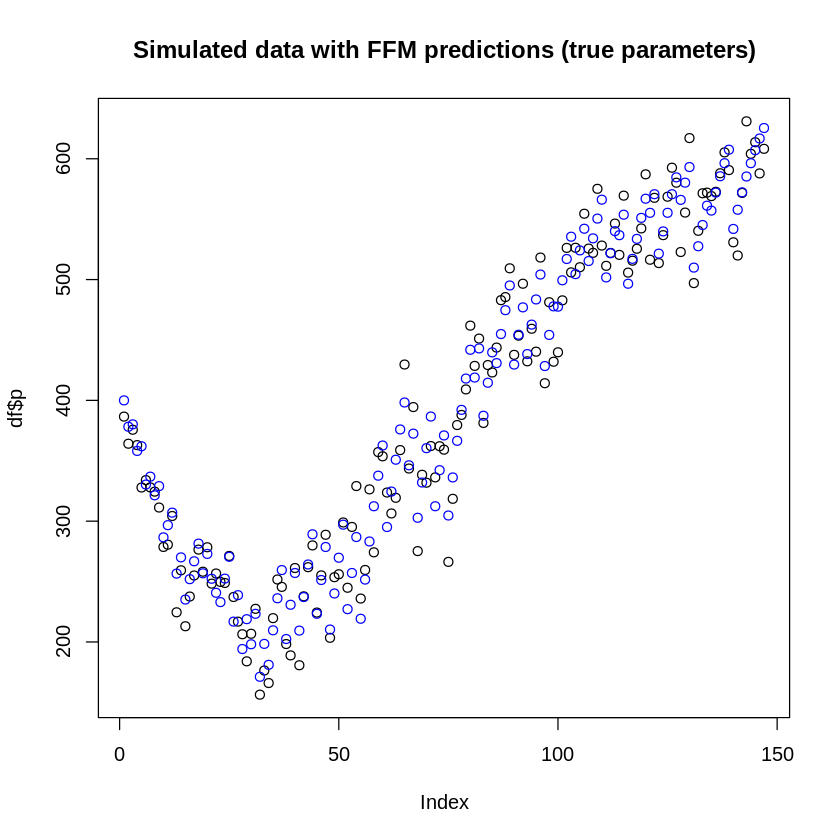

In [4]:
df <- simulate(ffm_basic, w)

# Predictions with true parameters
pred_true_df <- make_predictions(ffm_basic, w)
plot(df$p, main = "Simulated data with FFM predictions (true parameters)")
points(pred_true_df$p_hat, col = 'blue')

### Estimation in the basic model
Below we approach estimation of the unknown parameters of the basic Fitness Fatigue Model. As this is a non-convex estimation problem, good starting values are important. In our review, we describe an approach to data-driven starting values. This is implemented below. Note that the initialization results in a valid model in itself.

For the basic model, the inputs to the initialization are the data set and a course grid of potential time constants. These have default values but are specified below for transparency.

In [5]:
# Estimating basic model, first get starting values from data set
ffm_from_data <- initialize_ffm_from_data(df, tau_g_seq = c(10, 50, 90),
                                          tau_h_seq = c(5, 10, 20))
print(ffm_from_data)

The best combination------
  tau_g tau_h tau_h2 delta gamma   p_star       k_g      k_h    sigma fitness_0
6    90    10     NA    NA    NA 393.0885 0.5678166 3.057406 20.31093         0
  fatigue_0
6         0

------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

\hat{p}_n = 393.0885 + 0.5678166 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 90)
          - 3.057406 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 10)
          + \epsilon_n
where

\epsilon_n ~ N(0, 20.31093 ^ 2)


#### Maximum Likelihood Estimation
Maximum Likelihood Estimation is performed with R's base `optim` function using the L-BFGS-B algorithm. The method of choosing starting values and upper and lower bounds is described in the review.

In [6]:
# One-shot maximum likelihood using L-BFGS-B
ffm_ml <- maximize_likelihood(ffm_from_data, df)
print(ffm_ml)


Starting L-BFGS-B optimization via optim.
Depending on the model, this could take a few minutes...
Factor of machine tolerance for relative convergence: 10 

------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

\hat{p}_n = 390.1482 + 0.8198831 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 68.28201)
          - 2.881211 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 13.39578)
          + \epsilon_n
where

\epsilon_n ~ N(0, 19.09006 ^ 2)


#### Gradient Descent
The gradient vector of the sum of squared residuals with respect to the fitness fatigue model is analytically tractible and may be used in a gradient descent algorithm. This method is included for comparison with the L-BFGS-G method used in R's base `optim` function. While it is possible to reduce the error dramatically from an intial condition, scaling is important.

This procedure normalizes the gradient, then applies individual scaling of the parameters before applying the usual $\lambda$ tuning rate parameter (See [jermwatt.github.io](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_9_Normalized.html) for an explanation.) It may be necessary to run the algorithm multiple times with different scalings and values of $\lambda$. The method is thus

$$
\theta_k^{\star} = \theta_{k - 1}^{\star} - \lambda \frac{\nabla g(\theta_{k - 1})}{\Vert \nabla g(\theta_{k - 1}) \Vert_2 }
$$

where $\theta$ are the 5 unknown model expectation parameters (i.e., not including error variance), $\theta_k^{\star}$ is $\theta$ after elementwise division with a parameter scaling vector (`parscale` below), and $g(\cdot)$ is the residual mean squared error function.

For demonstration purposes, the starting values will be strategically far away from their true values. As the user will see, it's challenging to match the performance of L-BFGS-B, and multiple rescalings are necessary. Note the parameters that move and the ones that don't

In [7]:
# Demonstration - to get feel for Gradient Descent

ffm_close <- create_ffm_model(p_star = 385, k_g = .5, k_h = 2.5, tau_g = 52,
                              tau_h = 12, sigma = 15)

# Initial try - note that p_star isn't moving much
ffm_gd <- increase_likelihood_by_gradient(ffm_close, df, reps = 1000,
                                          lambda = .001, thin = 100)

# Adjust parscale so that p_star moves
ffm_gd <- increase_likelihood_by_gradient(ffm_gd, df, reps = 2000,
                                          lambda = .001, thin = 200,
                                          parscale = c(.001, 4, 1, .05, .25))
print(ffm_gd)

Rep 100 , Parameters: 385.0208 0.5971538 2.476937 52.00758 11.94678 RMSE: 82.78978 
Rep 200 , Parameters: 385.0401 0.6951212 2.457631 52.01776 11.8979 RMSE: 52.18128 
Rep 300 , Parameters: 385.0303 0.769332 2.497839 52.04577 11.92301 RMSE: 43.62444 
Rep 400 , Parameters: 384.9932 0.8011081 2.592033 52.08669 12.02347 RMSE: 40.33095 
Rep 500 , Parameters: 384.9581 0.8334112 2.686003 52.12958 12.12718 RMSE: 37.11773 
Rep 600 , Parameters: 384.9258 0.8662872 2.779723 52.1746 12.23459 RMSE: 34.01645 
Rep 700 , Parameters: 384.8969 0.899792 2.873155 52.22199 12.34649 RMSE: 31.07021 
Rep 800 , Parameters: 384.8727 0.9340176 2.966239 52.27214 12.46421 RMSE: 28.33768 
Rep 900 , Parameters: 384.8554 0.9691307 3.058862 52.32573 12.59033 RMSE: 25.89731 
Rep 1000 , Parameters: 384.8497 1.005478 3.150777 52.38411 12.73028 RMSE: 23.84917 

Raw gradient is -27.83944 -37056.33 -91129.68 -6139.451 -14972.6 
Normalized gradient is -0.0002792381 -0.3716864 -0.9140586 -0.06158057 -0.1501798 
Normalized gra

## Incorporating initial values

To the basic 5-parameter Fitness Fatigue Model, we now relax the assumption of zero initial fitness and fatigue effects and add the parameters $q_g$ and $q_h$. These have the interpretation of fitness and fatigue present at time $i=0$ with a zero training impulse at time $i=0$.

$$
\begin{align}
\hat{p}_n = p^{\star} &+ k_g \sum_{i=1}^{n-1} \omega_i \cdot e^{-\frac{(n-i)}{\tau_g}}
 - k_h \sum_{i=1}^{n-1} \omega_i \cdot e^{-\frac{(n-i)}{\tau_h}} \\
 &+ q_g \cdot e^ {-\frac{n}{\tau_g}} + q_h \cdot e ^ {-\frac{n}{\tau_h}}.
\end{align}
$$


In [8]:
ffm_add_initial <- create_ffm_model(p_star = 400, k_g = 1, k_h = 3, tau_g = 60,
                                    tau_h = 15, sigma = 20, q_g = 500, q_h = 250)
print(ffm_add_initial)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: TRUE ---

\hat{p}_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 60)
          - 3 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 15)
          + 500 * \exp(-n / 60) + 250 * \exp(-n  / 15)
          + \epsilon_n
where

\epsilon_n ~ N(0, 20 ^ 2)


#### Visual Confirmation of non-zero offsets
In the data frame head and plots below, confirm that fitness and fatigue have non-zero offsets.

In [9]:
df <- simulate(ffm_add_initial, w)
head(df, 5)  # Look for fitness and fatigue to be around their starting values

,t,w,p,p_hat,w_ffm,g,h
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,207.1338,190.1055,11.97,491.7357,233.8767
2,2,0.00,239.3427,205.4062,0.00,495.3802,229.9913
3,3,13.07,258.9814,241.7168,13.07,487.1923,215.1585
4,4,0.00,227.6001,251.4656,0.00,491.9937,213.5094
5,5,19.35,306.2869,284.6432,19.35,483.8617,199.7395


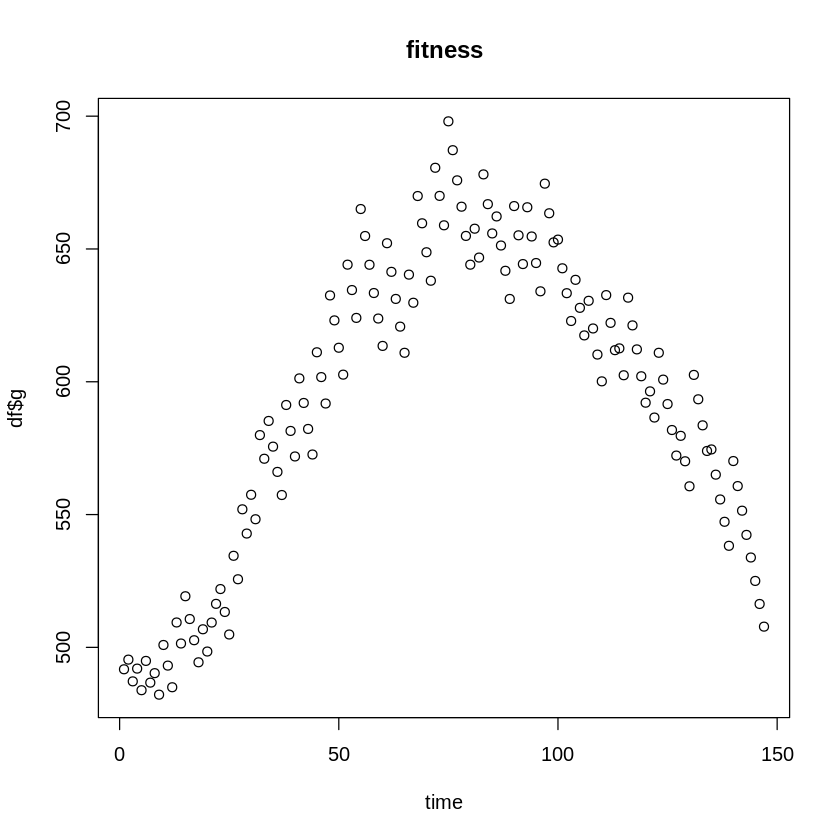

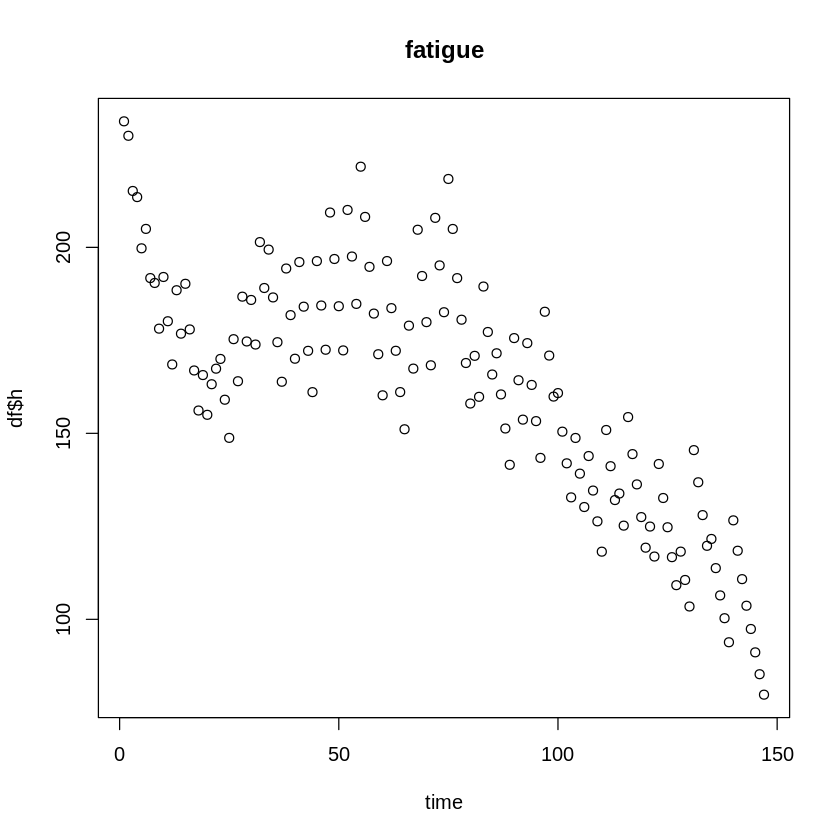

In [10]:
# See the initial values at work
plot(df$g, main = "fitness", xlab = "time")
plot(df$h, main = "fatigue", xlab = "time")

In [11]:
ffm_from_data <- initialize_ffm_from_data(df, estimate_initial = TRUE)

The best combination------
  tau_g tau_h tau_h2 delta gamma   p_star       k_g     k_h    sigma fitness_0
5   100     5     NA    NA    NA 371.9657 0.4144181 1.76343 39.35075  193.5027
  fatigue_0
5  64.53208


In [12]:
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_initial = TRUE)
print(ffm_ml)



Tuning Initial parameters (q_g, q_h) with lower bound: 0 0 
  and upper bound: 2071.338 2071.338 
  and starting values: 193.5027 64.53208 

Starting L-BFGS-B optimization via optim.
Depending on the model, this could take a few minutes...
Factor of machine tolerance for relative convergence: 10 

------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: FALSE , Initial Fitness & Fatigue: TRUE ---

\hat{p}_n = 656.8174 + 2.35569 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 28.56777)
          - 4.457421 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 17.27667)
          + 190.3279 * \exp(-n / 28.56777) + 211.2812 * \exp(-n  / 17.27667)
          + \epsilon_n
where

\epsilon_n ~ N(0, 19.67538 ^ 2)


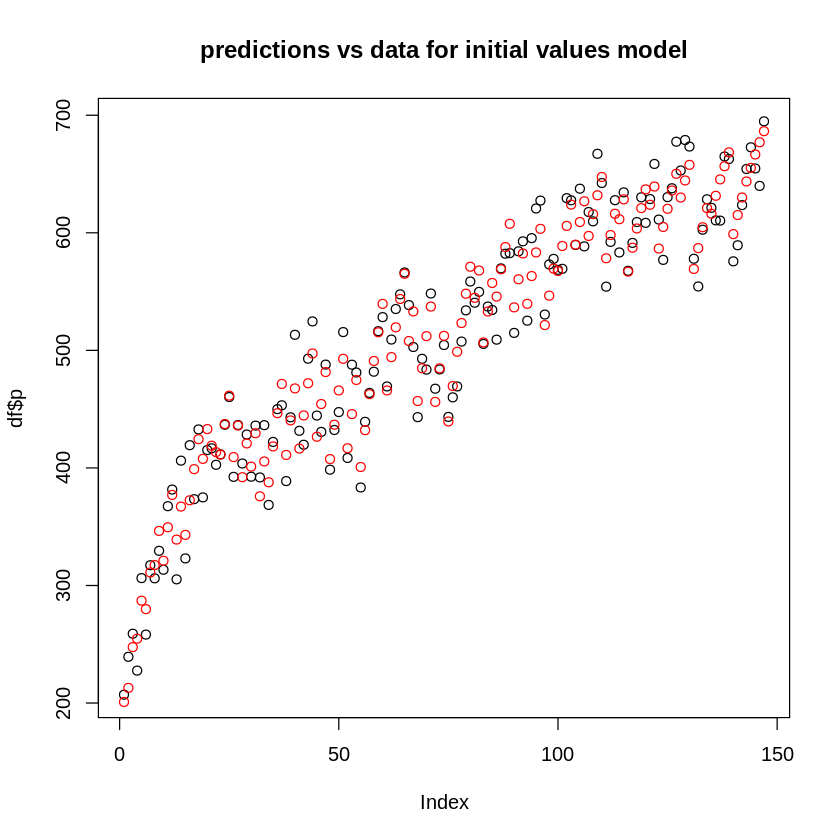

In [13]:
# Predictions with estimated model
pred_df <- make_predictions(ffm_ml, w)
plot(df$p, main = "predictions vs data for initial values model")
points(pred_df$p_hat, col = 'red')

## The Variable Dose-Response (VDR) Model

We now relax the assumption that the daily increase in fatigue depends only on the previous workout. In the variable dose-response (VDR) model, the daily increase to fatigue may depends on past training loads in an exponentially decaying manner.
$$
\begin{align}
\hat{p}_n = p^{\star} &+ k_g \sum_{i=1}^{n-1} \omega_i \cdot e^{-\frac{(n-i)}{\tau_g}}
 - k_h \sum_{i=1}^{n-1} k_{h_2} ^ i \cdot e^{-\frac{(n-i)}{\tau_h}} \\
 &+ q_g \cdot e^ {-\frac{n}{\tau_g}} + q_h \cdot e ^ {-\frac{n}{\tau_h}},
\end{align}
$$

where
$$
k_{h_2} ^ i = \sum_{j=1}^i \omega_j \cdot e^{-\frac{(i-j)}{\tau_{h_2}}}.
$$

Below, notice how we brough down the value of $k_h$ from 3 to 1.5. If you set it at 3, you'll be in for some massive swings as fatigue now accumulates over multiple days.

In [14]:
ffm_vdr <- create_ffm_model(p_star = 400, k_g = 1, k_h = 1.5, tau_g = 60,
                            tau_h = 15, sigma = 20,
                            tau_h2 = 3, 
                            q_g = 300, q_h = 250)
print(ffm_vdr)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

\hat{p}_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 60)
          - 1.5 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp(-(n - i) / 15)
          + 300 * \exp(-n / 60) + 250 * \exp(-n  / 15)
          + \epsilon_n
where

k^i_h2 = \sum_{j = 1}^i w_i * \exp(-(i - j) / 3)

and

\epsilon_n ~ N(0, 20 ^ 2)


In [15]:
df <- simulate(ffm_vdr, w)
head(df, 5)

,t,w,p,p_hat,w_ffm,g,h
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,345.6154,344.2263,11.97,295.0414,233.8767
2,2,0.00,395.5161,373.7470,0.00,301.9370,218.7933
3,3,13.07,356.9971,381.2985,13.07,296.9464,210.4319
4,4,0.00,356.3597,390.2805,0.00,304.8923,209.7412
5,5,19.35,366.5826,391.6873,19.35,299.8529,205.4437


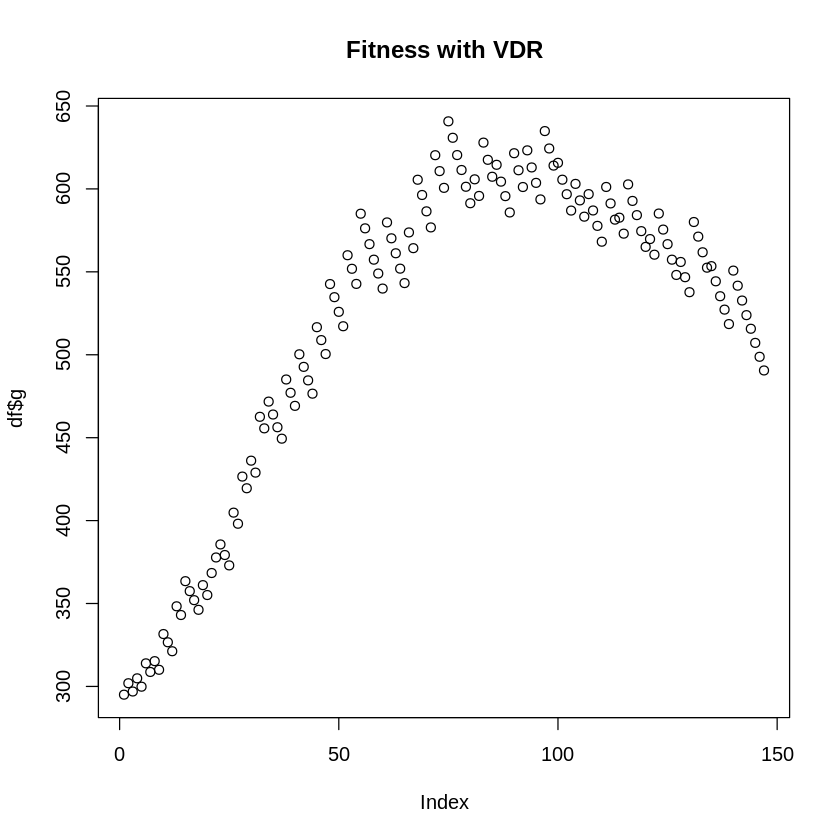

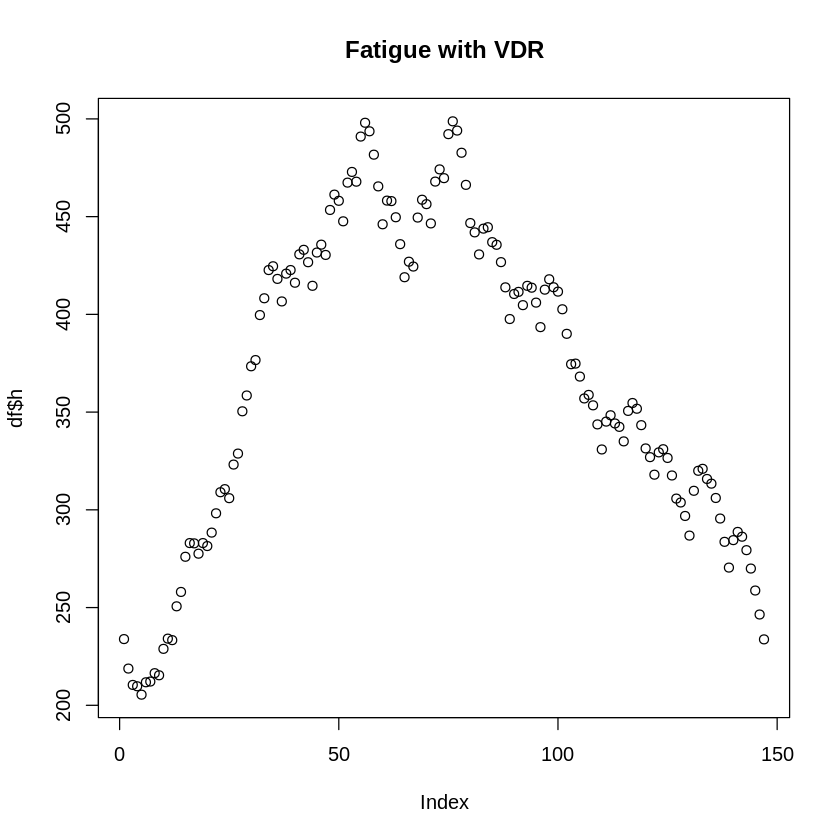

In [16]:
# Fatigue can get pretty large with tau_h and tau_h2
plot(df$g, main = "Fitness with VDR")
plot(df$h, main = "Fatigue with VDR")

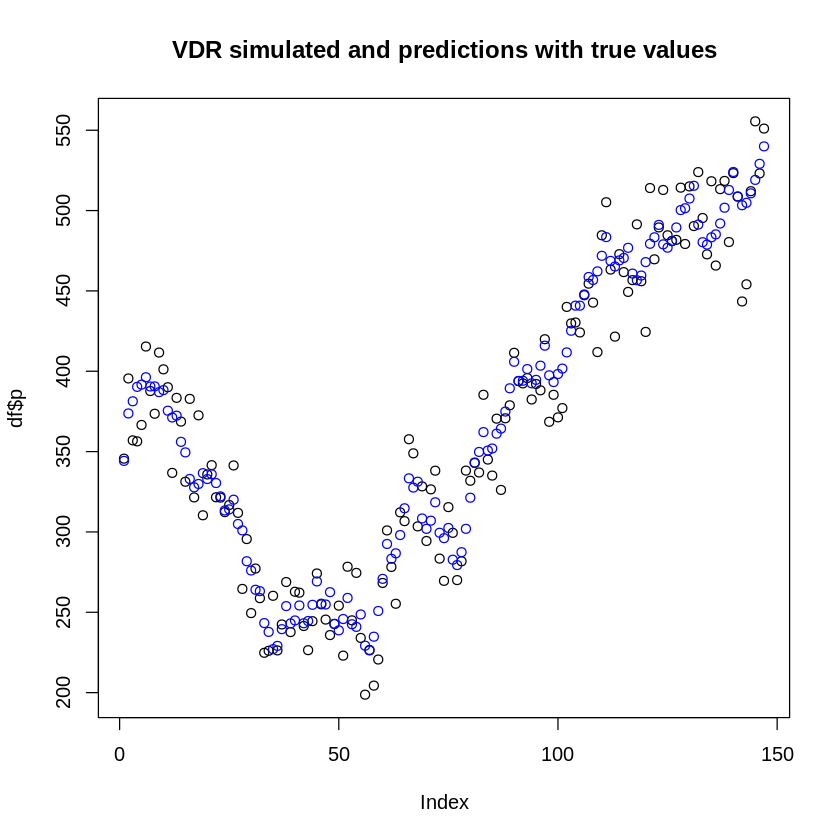

In [17]:
# Predictions with true parameters
pred_true_df <- make_predictions(ffm_vdr, w)
plot(df$p, main = "VDR simulated and predictions with true values")
points(pred_true_df$p_hat, col = 'blue')

#### Estimation of VDR parameters
Note that we include a time constant sequence for the new $\tau_{h_2}$ parameter in `initialize_ffm_from_data`.

In [18]:
# Specify tau_h2_seq for data-driven VDR starting values
ffm_from_data <- initialize_ffm_from_data(df,
                                          tau_g_seq = c(10, 50, 80),
                                          tau_h_seq = c(5, 10, 20),
                                          tau_h2_seq = c(1, 2, 5, 10, 15),
                                          estimate_initial = TRUE)

The best combination------
   tau_g tau_h tau_h2 delta gamma   p_star       k_g       k_h    sigma
27    80    20      5    NA    NA 394.8466 0.7248566 0.4711153 25.07454
   fitness_0 fatigue_0
27  210.4503  759.4761


In [19]:
# One-shot maximum likelihood using L-BFGS-B
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_initial = TRUE, tune_vdr = TRUE)
print(ffm_ml)



Tuning Initial parameters (q_g, q_h) with lower bound: 0 0 
  and upper bound: 3456.154 3456.154 
  and starting values: 210.4503 759.4761 


Tuning VDR parameter tau_h2 with lower bound: 1 
  and upper bound: 147 
  and starting value: 5 

Starting L-BFGS-B optimization via optim.
Depending on the model, this could take a few minutes...
Factor of machine tolerance for relative convergence: 10 

------- Your Fitness Fatigue Model ---------
--- Hill Transform: FALSE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

\hat{p}_n = 416.9088 + 1.166581 * \sum_{i = 1}^{n - 1} w_i * \exp(-(n - i) / 54.82297)
          - 1.703396 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp(-(n - i) / 16.33564)
          + 281.0483 * \exp(-n / 54.82297) + 248.8473 * \exp(-n  / 16.33564)
          + \epsilon_n
where

k^i_h2 = \sum_{j = 1}^i w_i * \exp(-(i - j) / 2.744399)

and

\epsilon_n ~ N(0, 20.44599 ^ 2)


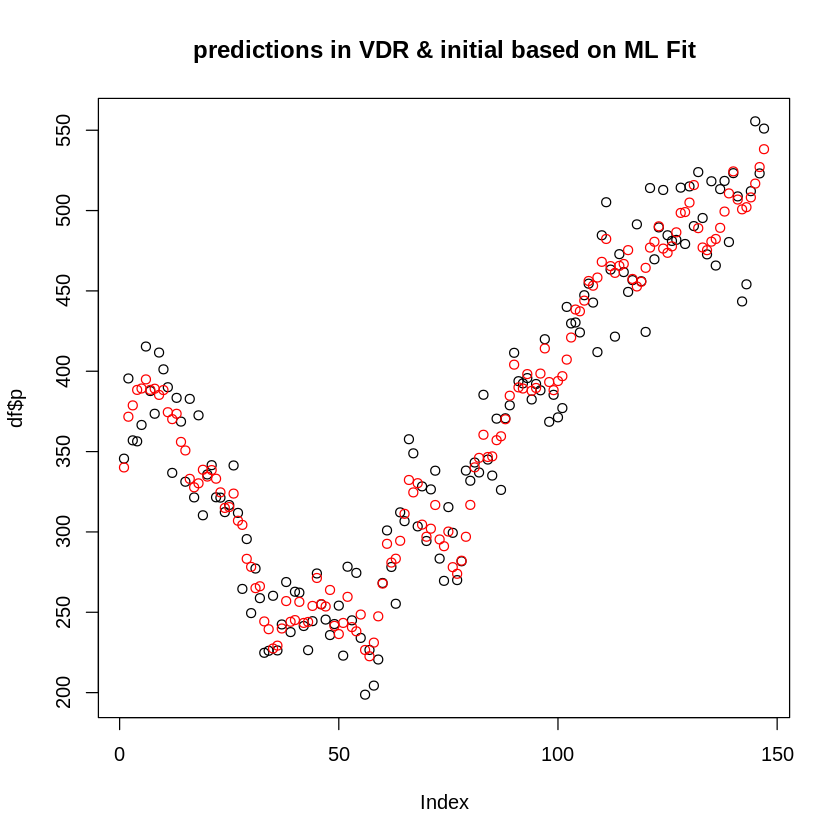

In [20]:
pred_df <- make_predictions(ffm_ml, w)
plot(df$p, main = "predictions in VDR & initial based on ML Fit")
points(pred_df$p_hat, col = 'red')

## Using the Hill function
The Hill function is defined as

$$
Hill(\omega) = \kappa \left( \frac{\omega^\gamma}{\delta^\gamma + \omega^\gamma}\right)
$$
and, when used as a transformation to the raw training inputs, may mitigate the non-linearity in the training dose-response profile. Below is a demonstration of the Hill function applied to the same raw inputs as before, first with the basic model and then with all the other optional parameters.

The model is thus:

$$
\hat{p}_n = p^{\star} + k_g \sum_{i=1}^{n-1} \omega_i^{\star} \cdot e^{-\frac{(n-i)}{\tau_g}}
 - k_h \sum_{i=1}^{n-1} \omega_i ^ {\star} \cdot e^{-\frac{(n-i)}{\tau_h}}
$$

where
$$
\omega_j^{\star} = \kappa \left( \frac{\omega_j^\gamma}{\delta^\gamma + \omega_j^\gamma}\right), j = 1, \ldots, n.
$$

In the following, $\kappa$ is not estimated but instead set to 100. This parameter is not estimable from data since $k_g$ and $k_h$ can "undo" the multiplier from $\kappa$. 

In [21]:
ffm_hill <- create_ffm_model(p_star = 400, k_g = 1, k_h = 3, tau_g = 60,
                             tau_h = 15, sigma = 20,
                             gamma = 2, delta = 10, kappa = 100)
print(ffm_hill)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

\hat{p}_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i_star * \exp(-(n - i) / 60)
          - 3 * \sum_{i = 1}^{n - 1} w_i_star * \exp(-(n - i) / 15)
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2 / (10 ^ 2 + w_i ^ 2)

and

\epsilon_n ~ N(0, 20 ^ 2)


### Hill function shape

Below we examine the hill function given the true values of the parameters used in this simulation, i.e., $\gamma = 2, \delta = 10, \kappa = 100$.

In [22]:
seq(min(w), max(w))

[1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
[26] 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
[51] 50 51 52 53

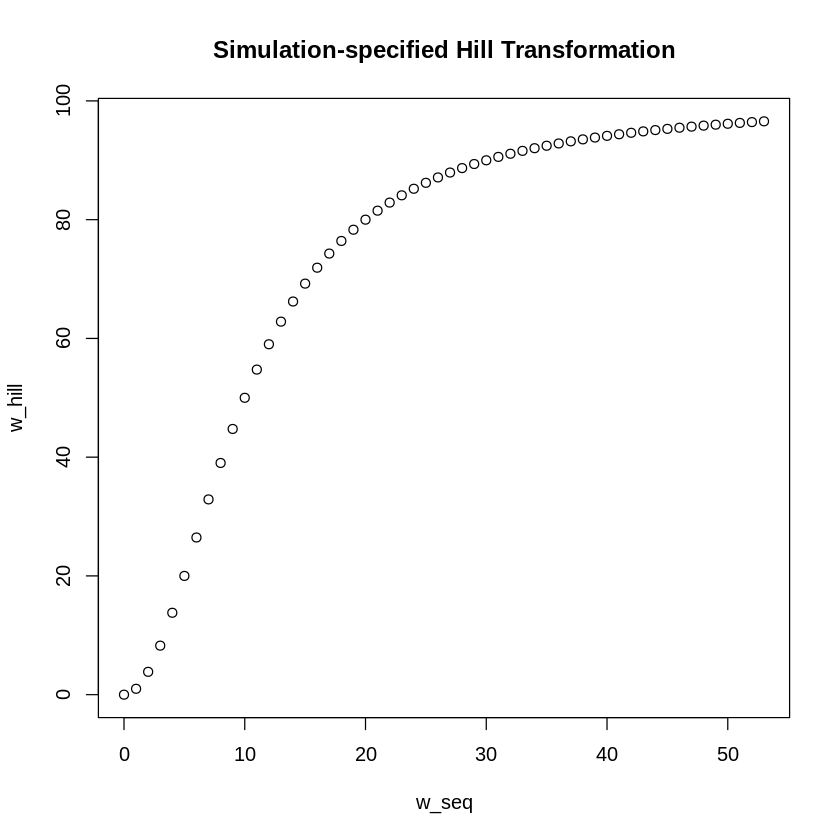

In [23]:
w_seq <- seq(min(w), max(w))  # dense grid of intensity values
w_hill <- get_hill_transformed_training(ffm_hill, w_seq)
plot(w_hill ~ w_seq, main = "Simulation-specified Hill Transformation")

In [24]:
df <- simulate(ffm_hill, w)
head(df)

,t,w,p,p_hat,w_ffm,g,h
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,387.20457,400.00000,58.89525,0.00000,0.00000
2,2,0.00,321.00735,292.63104,0.00000,57.92180,55.09692
3,3,13.07,305.51323,302.33378,63.07577,56.96444,51.54355
4,4,0.00,211.25361,196.37458,0.00000,118.05612,107.22718
5,5,19.35,213.64234,215.16949,78.92174,116.10482,100.31178
6,6,0.00,99.71801,88.78043,0.00000,191.80306,167.67421


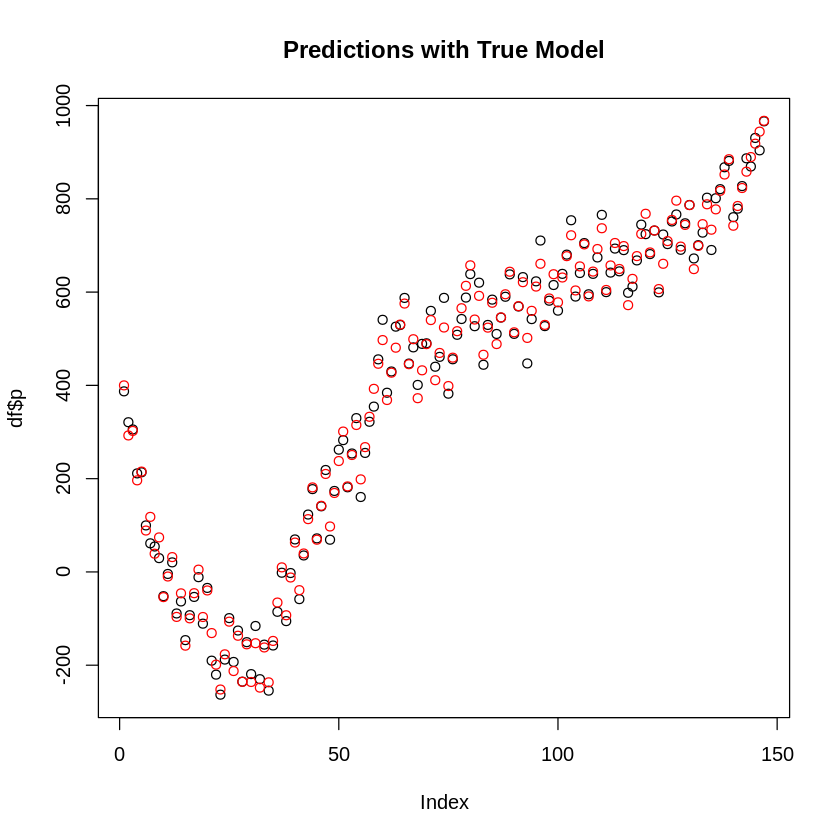

In [25]:
# Predictions with true model
pred_df <- make_predictions(ffm_hill, w)
plot(df$p, main = "Predictions with True Model")
points(pred_df$p_hat, col = 'red')

### Estimation of Hill Function parameters

We'll need to specify grids for $\delta$ and $\gamma$ to get data driven starting values. In this situation where the hill parameters are the only two additional parameters, Maximum Likelihood via the L-BFGS-B alorithm is able to recover parameters that match the shape of the hill function very closely. We'll see that when the model gets more complicated in the next section, the Hill parameters are harder to recover.

In [26]:
# Specify delta_seq and gamma_seq for data-driven hill starting values
ffm_from_data <- initialize_ffm_from_data(df,
                                          tau_g_seq = c(10, 50, 80),
                                          tau_h_seq = c(5, 10, 20),
                                          delta_seq = c(.3, 1, 1.5, 5, 20),
                                          gamma_seq = c(.3, 1, 2, 5, 20))

The best combination------
    tau_g tau_h tau_h2 delta gamma   p_star     k_g      k_h    sigma fitness_0
125    50    20     NA     5     2 426.3013 1.46236 3.053949 27.97813         0
    fatigue_0
125         0


In [27]:
# One-shot maximum likelihood using L-BFGS-B
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_hill = TRUE)
print(ffm_ml)



Tuning Hill parameters (delta, gamma) with lower bound: 0.1 0.1 
  and upper bound: 100 20 
  and starting values: 5 2 

Starting L-BFGS-B optimization via optim.
Depending on the model, this could take a few minutes...
Factor of machine tolerance for relative convergence: 10 

------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: FALSE , Initial Fitness & Fatigue: FALSE ---

\hat{p}_n = 397.2854 + 1.025677 * \sum_{i = 1}^{n - 1} w_i_star * \exp(-(n - i) / 58.57391)
          - 3.0413 * \sum_{i = 1}^{n - 1} w_i_star * \exp(-(n - i) / 14.93188)
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2.110702 / (10.23667 ^ 2.110702 + w_i ^ 2.110702)

and

\epsilon_n ~ N(0, 20.9405 ^ 2)


#### The Hill parameter estimates

Note that in the M****L estimation, $\hat{\gamma} = 2.15, \hat{\delta} = 9.46$, which is pretty close to the true values of $\gamma = 2, \delta = 10$. Thus, the shape of the estimated transformation is very close to the one used to simulate the data.

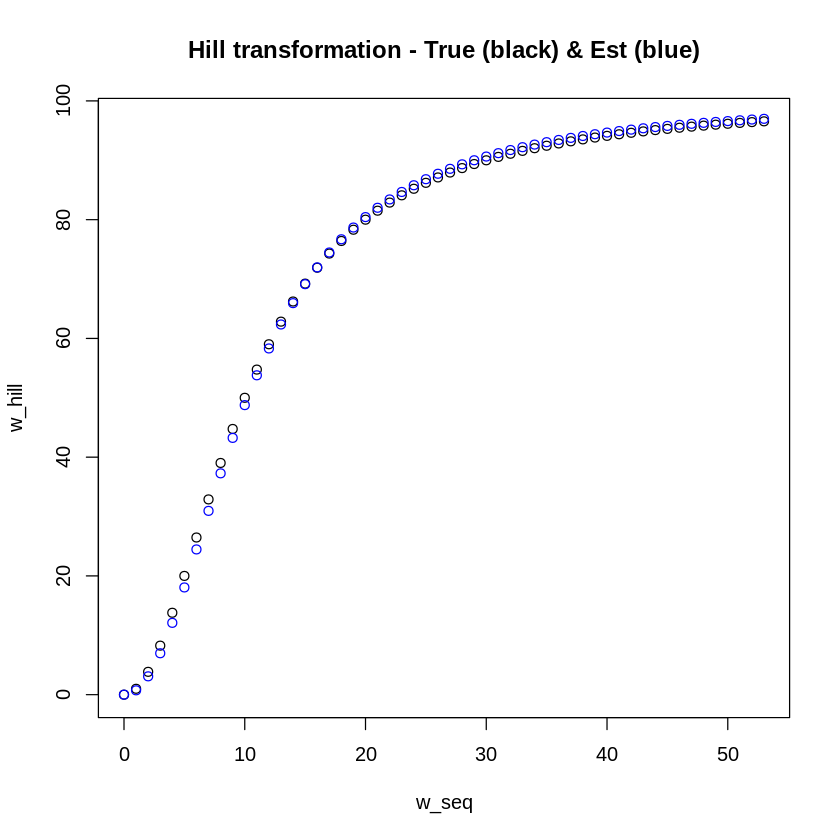

In [28]:
# Hill transformation analysis
w_hill_ml <- get_hill_transformed_training(ffm_ml, w_seq)
plot(w_hill ~ w_seq, 
     main = "Hill transformation - True (black) & Est (blue)")
points(w_hill_ml ~ w_seq, col = 'blue')

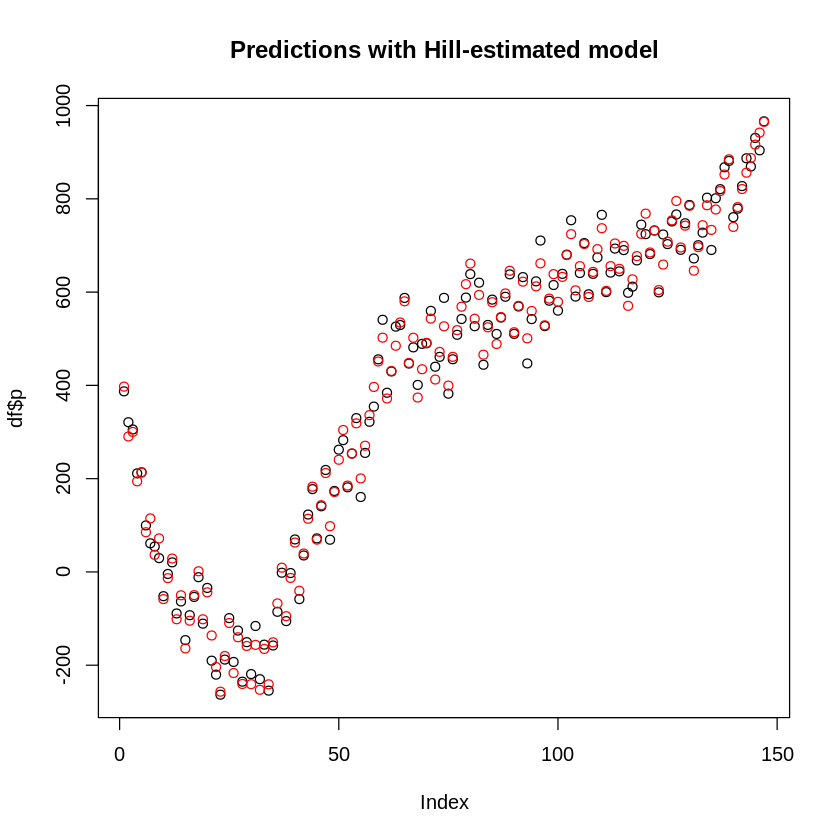

In [29]:
# Predictions with estimated model
pred_df <- make_predictions(ffm_ml, w)
plot(df$p, main = "Predictions with Hill-estimated model")
points(pred_df$p_hat, col = 'red')

## "The Works" Model: VDR, Initial Values, and Hill transformation
Fitting a model based on two variables with ten parameters in the expectation is ambitious, but below we go for it. The model here is

$$
\begin{align}
\hat{p}_n = p^{\star} &+ k_g \sum_{i=1}^{n-1} \omega_i^{\star} \cdot e^{-\frac{(n-i)}{\tau_g}}
 - k_h \sum_{i=1}^{n-1} k_{h_2} ^ i \cdot e^{-\frac{(n-i)}{\tau_h}} \\
 &+ q_g \cdot e^ {-\frac{n}{\tau_g}} + q_h \cdot e ^ {-\frac{n}{\tau_h}},
\end{align}
$$

where
$$
k_{h_2} ^ i = \sum_{j=1}^i \omega_j^{\star} \cdot e^{-\frac{(i-j)}{\tau_{h_2}}}
$$
and 
$$
\omega_j^{\star} = \kappa \left( \frac{\omega_j^\gamma}{\delta^\gamma + \omega_j^\gamma}\right), j = 1, \ldots, n.
$$

Again, $\kappa$ is not estimated but instead set to 100 for convenience.


In [30]:
ffm_the_works <- create_ffm_model(p_star = 400, k_g = 1, k_h = .9, tau_g = 60,
                                  tau_h = 15, sigma = 20, tau_h2 = 3,
                                  gamma = 2, delta = 10, kappa = 100,
                                  q_g = 300, q_h = 250)
print(ffm_the_works)


------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

\hat{p}_n = 400 + 1 * \sum_{i = 1}^{n - 1} w_i_star * \exp(-(n - i) / 60)
          - 0.9 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp(-(n - i) / 15)
          + 300 * \exp(-n / 60) + 250 * \exp(-n  / 15)
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 2 / (10 ^ 2 + w_i ^ 2)

and

k^i_h2 = \sum_{j = 1}^i w_i_star * \exp(-(i - j) / 3)

and

\epsilon_n ~ N(0, 20 ^ 2)


This model uses the same Hill function parameters as in the last section. Below is a reminder of its shape:

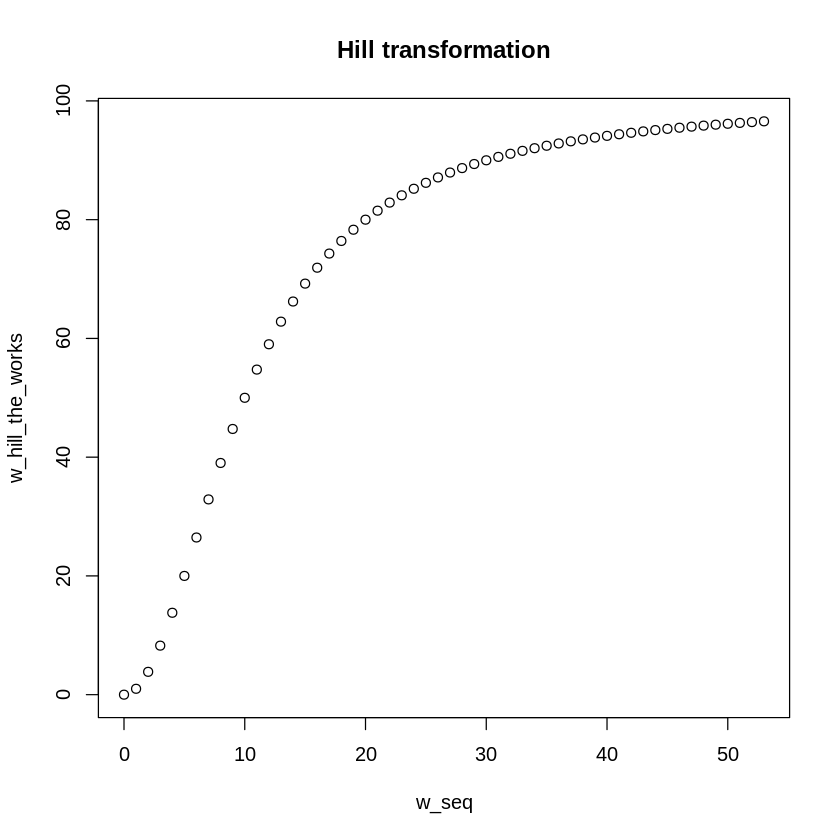

In [31]:
w_hill_the_works <- get_hill_transformed_training(ffm_the_works, w_seq)
plot(w_hill_the_works ~ w_seq, main = "Hill transformation")

### Simulation of Data generated by "The Works" Model

In [32]:
df <- simulate(ffm_the_works, w)
head(df)

,t,w,p,p_hat,w_ffm,g,h
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,11.97,464.2410,484.5524,58.89525,295.0414,233.8767
2,2,0.00,546.4675,551.1726,0.00000,348.0866,218.7933
3,3,13.07,530.1037,532.6599,63.07577,342.3333,232.9704
4,4,0.00,572.7974,546.2623,0.00000,398.7082,280.4954
5,5,19.35,487.0663,515.6162,78.92174,392.1181,307.2244
6,6,0.00,548.9443,528.0694,0.00000,463.2543,372.4277


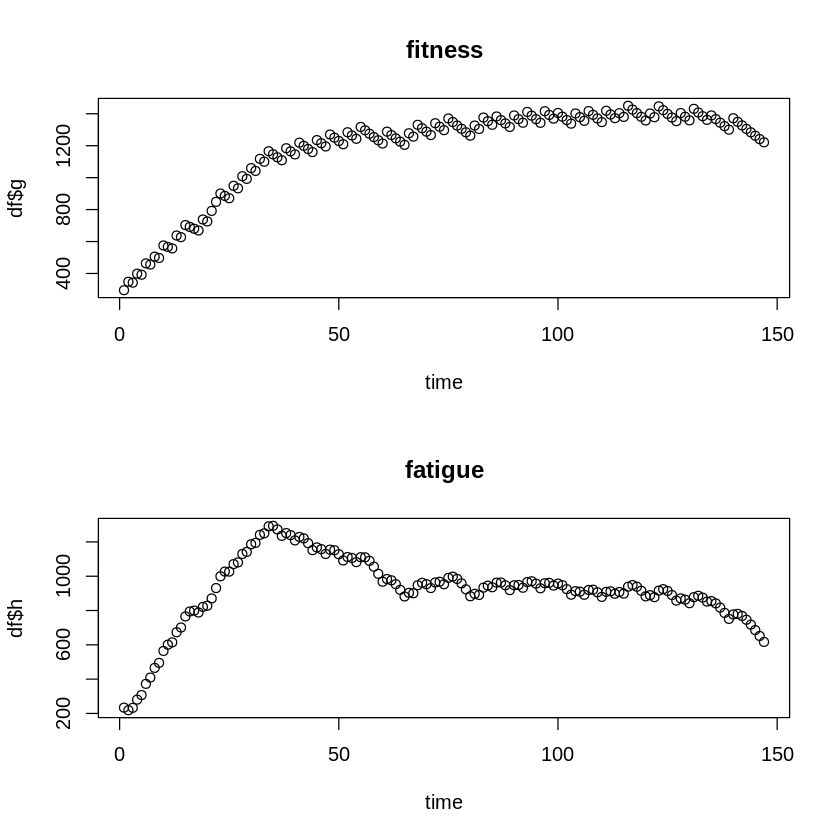

In [33]:
# True fitness and fatigue paths simulated
par(mfrow = c(2, 1))
plot(df$g, main = "fitness", xlab = "time")
plot(df$h, main = "fatigue", xlab = "time")

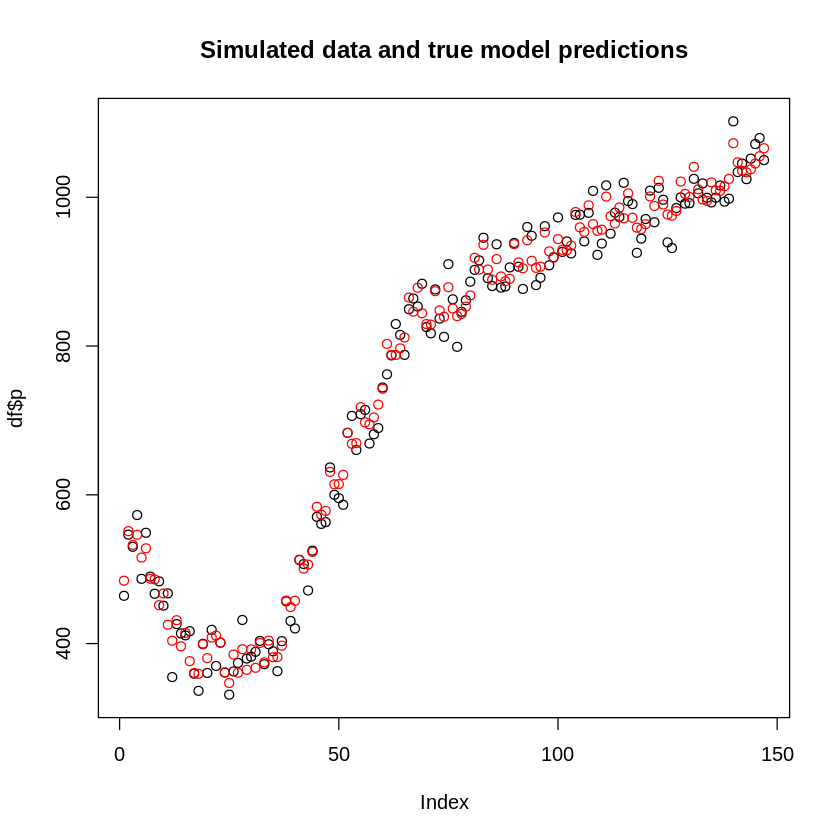

In [34]:
# Model-based performance predictions
pred_df <- make_predictions(ffm_the_works, w)
plot(df$p, main = "Simulated data and true model predictions")
points(pred_df$p_hat, col = 'red')

### Estimation in "The Works" model
The initialization routine gets more complex, as now the grid must include sequences for $\tau_{h_2}$ (of the VDR) in addition to $\gamma$ and $\delta$ (of the Hill transformation). While the grid has become very large, as each iteration is a closed form regression the starting value-generating procedure still returns fairly quickly.

In [35]:
ffm_from_data <- initialize_ffm_from_data(df,
                                          tau_g_seq = c(10, 50, 80),
                                          tau_h_seq = c(5, 10, 20),
                                          tau_h2_seq = c(1, 2, 5, 10),
                                          delta_seq = c(.3, 1, 1.5, 5, 20),
                                          gamma_seq = c(.3, 1, 2, 5, 20),
                                          estimate_initial = TRUE)

The best combination------
    tau_g tau_h tau_h2 delta gamma   p_star      k_g      k_h    sigma
485    50    20      2     5     2 499.1777 1.205735 1.309755 23.00817
    fitness_0 fatigue_0
485  849.6646  916.9941


In [36]:
ffm_ml <- maximize_likelihood(ffm_from_data, df, tune_initial = TRUE,
                              tune_vdr = TRUE, tune_hill = TRUE)
print(ffm_ml)



Tuning Initial parameters (q_g, q_h) with lower bound: 0 0 
  and upper bound: 4642.41 4642.41 
  and starting values: 849.6646 916.9941 


Tuning Hill parameters (delta, gamma) with lower bound: 0.1 0.1 
  and upper bound: 100 20 
  and starting values: 5 2 


Tuning VDR parameter tau_h2 with lower bound: 1 
  and upper bound: 147 
  and starting value: 2 

Starting L-BFGS-B optimization via optim.
Depending on the model, this could take a few minutes...
Factor of machine tolerance for relative convergence: 10 

------- Your Fitness Fatigue Model ---------
--- Hill Transform: TRUE , VDR: TRUE , Initial Fitness & Fatigue: TRUE ---

\hat{p}_n = 249.5889 + 0.8031278 * \sum_{i = 1}^{n - 1} w_i_star * \exp(-(n - i) / 80.93024)
          - 0.5675719 * \sum_{i = 1}^{n - 1} k^i_h2 * \exp(-(n - i) / 18.80874)
          + 849.612 * \exp(-n / 80.93024) + 916.4261 * \exp(-n  / 18.80874)
          + \epsilon_n
where

w_i_star = 100 * w_i ^ 3.653348 / (2.777798 ^ 3.653348 + w_i ^ 3.653348)

and



#### The Estimates of "The Works" Model

Estimation in "The Works" model constitutes an ambitious task. Here's how the final set of estimates came out:

- $\hat{p}^{\star} = 330.2$ vs $p^{\star} = 400$ (Basic)
- $\hat{k}_g = .65$ vs $k_g = 1$ (Basic)
- $\hat{k}_h = .5$ vs $k_h = .9$ (Basic)
- $\hat{\tau}_g = 90.8$ vs $\tau_g = 60$ (Basic)
- $\hat{\tau}_h = 17.2$ vs $\tau_h = 15$ (Basic)
- $\hat{\sigma} = 22.5$ vs $\sigma = 20$ (Basic)
- $\hat{q}_g = 849.5$ vs $q_g = 300$ (Initial) 
- $\hat{q}_h = 916.6$ vs $q_h = 250$ (Initial) 
- $\hat{\tau}_{h_2} = 3.86$ vs $\tau_{h_2} = 3$ (VDR)
- $\hat{\gamma} = 4.7$ vs $\gamma = 2$
- $\hat{\delta} = 4.4$ vs $\delta = 10$

The initial values were estimated very poorly, and many other parameters have high relative error rates. The goodness of fit of the model, as shown by its predictions below, show how flexible this model is and how slippery the estimation problem.


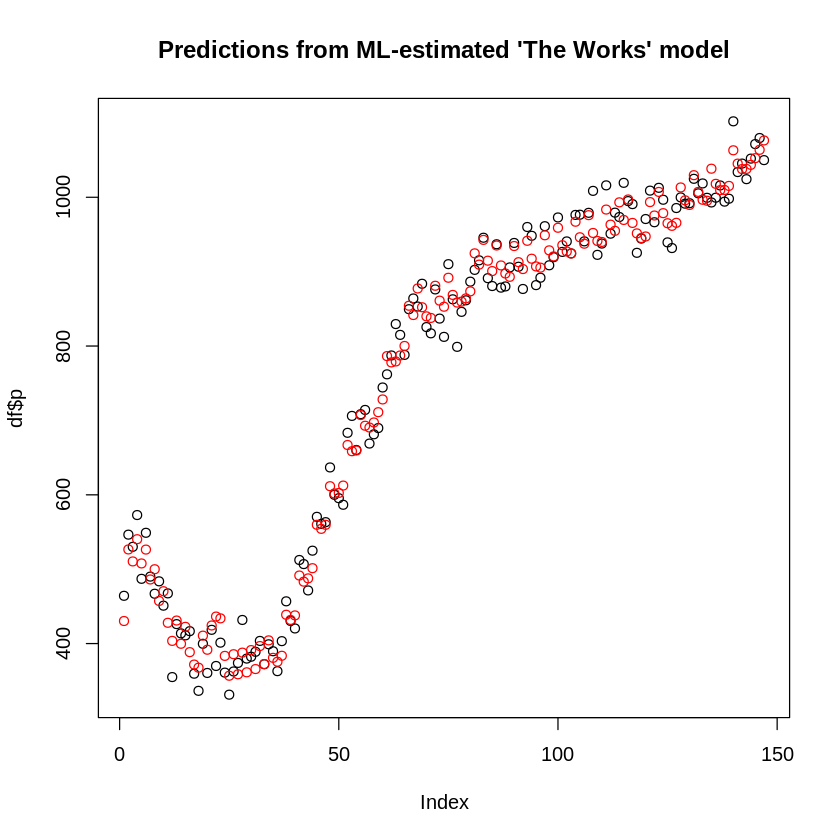

In [37]:
# Predictions with estimated model
pred_df <- make_predictions(ffm_ml, w)
plot(df$p, main = "Predictions from ML-estimated 'The Works' model")
points(pred_df$p_hat, col = 'red')

#### Hill function estimation

The Hill function parameters were also estimated quite poorly, and this is apparent visually as well. The estimated curve saturates very quickly, making the curve behave more like a switch that turns on after a moderate training intensity and stays off otherwise. Remember that, in spite of this, the fitted performance values were still quite close to the true values!

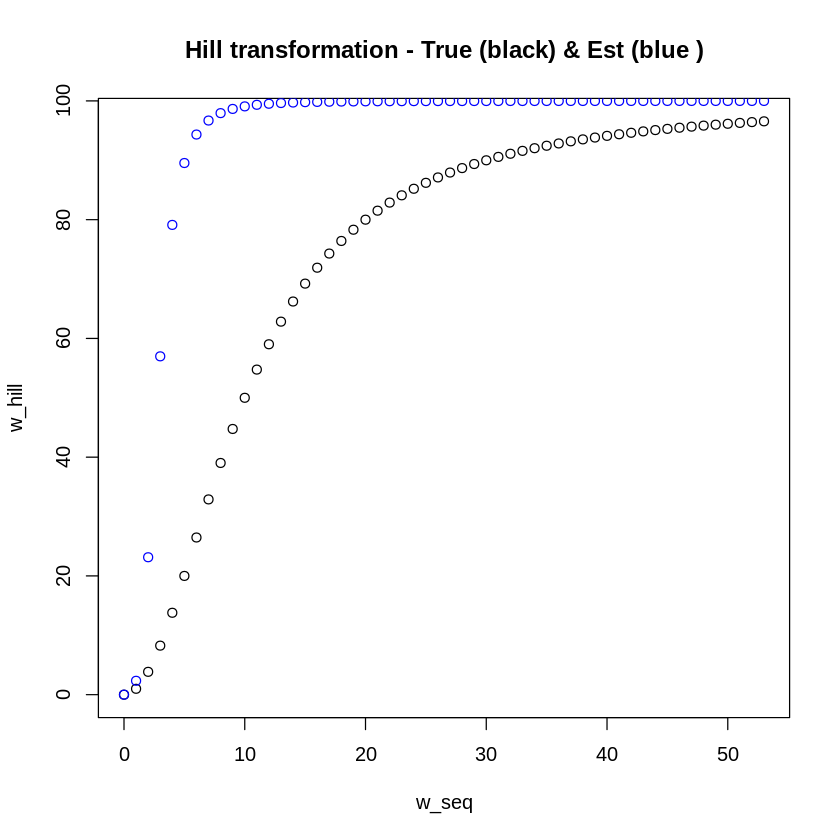

In [38]:
w_hill_ml <- get_hill_transformed_training(ffm_ml, w_seq)
plot(w_hill ~ w_seq, 
     main = "Hill transformation - True (black) & Est (blue )")
points(w_hill_ml ~ w_seq, col = 'blue')